In [1]:
import torch
from tqdm import tqdm
torch.__version__

'2.0.1+cu118'

In this day 4 challenge we are going to implement a Convolutional Neural Network. We are going to use MNIST dataset to train the network.</br>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Comparison_image_neural_networks.svg/512px-Comparison_image_neural_networks.svg.png" alt="LeNet Architecture"></img></br>

<h5> Source: Wikipedia </h5>


In [3]:
#!nvidia-smi

# the following line of code is used for setting the device for traing
# if we have a gpu it will set as GPU otherwise default machine
# Note that recent GPU's are significantly faster than CPUs

device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 2. Import Dataset

* `torch.utils.data` is a pytorch api to create your own dataset to train your models
* `torchvision.datasets` is a collection of preexisting datasets
* `ToTensor()` is used for converting data to appropriate format for operations

In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [5]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 162754153.42it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 21697240.52it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 139808183.16it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22760488.37it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
# print(f"Train data has {len(train_data)} images")
# print(f"Train data has {len(train_data)} images")

### 3. Visulaize the Dataset

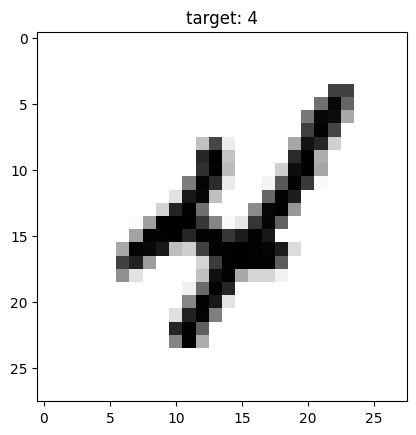

In [7]:
image, target = train_data[9] # we will pick 10th datapoint

plt.imshow(image.permute(1,2,0), cmap ="binary")
plt.title(f"target: {target}")
plt.show()

print()
# permute is to represent data correctly
# the  PyTorch format is (1, 28, 28) that is (Channel, Height, Width)
# While the imshow function expects data in numpy array format that is (Height, Width, Channel)
# i.e. (28, 28, 1) in our case

In [8]:
# rand_idx = torch.randint(0,len(train_data), size=(1,)).item()
# print(rand_idx)
# image, target = train_data[rand_idx]
# print(image, label)

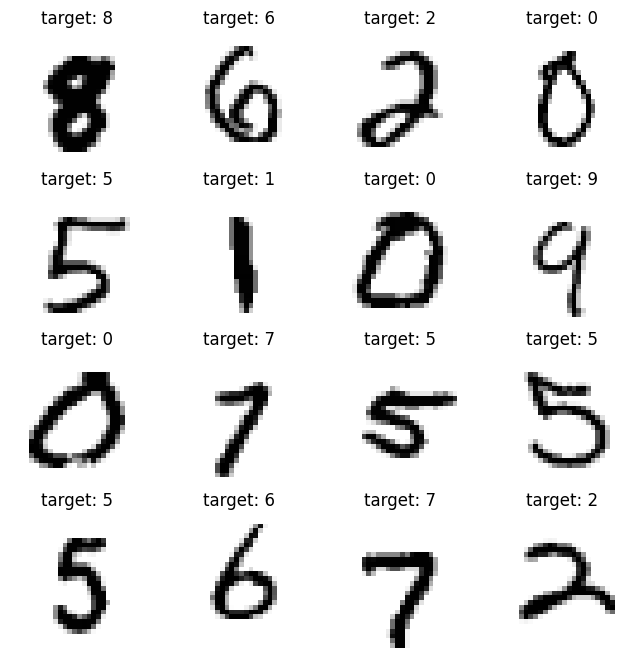

In [9]:
# Let's visualize some more images

figure = plt.figure(figsize=(8,8))
cols, rows = 4, 4
# we will randomly select 16 data instances to plot
for i in range(1, rows* cols + 1):
  random_idx = torch.randint(0,len(train_data), size=(1,)).item()
  image, target = train_data[random_idx]
  figure.add_subplot(rows, cols, i)
  plt.imshow(image.permute(1,2,0), cmap="binary")
  plt.title(f"target: {target}")
  plt.axis("off")
plt.show()

### 3. Set up Dataloader
* It isn't always necessary to use dataloader but it makes easy for us to shuffle the data and split into batches
* Exlpore More About the Batch Size: [Article on Batch Size]("https://deeplizard.com/learn/video/U4WB9p6ODjM") by DeepLizard

In [10]:
# Batch Size

BATCH_SIZE = 16

train_dataloader = DataLoader(dataset = train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers = 8)
# test data
test_dataloader = DataLoader(dataset = test_data,
                              shuffle=True,
                              num_workers = 8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Our data is ready for training a model. Now let's build a model. We are going to build classic LeNet-5 for this experiment.

### 4. Build the Model

In [11]:
import torch.nn as nn

In [12]:
class LeNet(nn.Module):
  def __init__(self,
               input_shape,
               classes):
    super().__init__()
    self.Layer1 = nn.Conv2d(in_channels = input_shape, out_channels =6, padding=2, kernel_size=(5,5))
    self.Maxpool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
    self.Layer2 = nn.Conv2d(in_channels=6, out_channels = 16, padding = 0, kernel_size=(5,5))
    self.Maxpool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
    self.Dense1 = nn.Linear(16*5*5,120)
    self.Dense2 = nn.Linear(120,84)
    self.Dense3 = nn.Linear(84,10)
    self.Relu = nn.ReLU()
    self.flatten = nn.Flatten()

  def forward(self, x):
    # print("Input",x.shape)
    x = self.Layer1(x)
    # print("Cov1",x.shape)
    x = self.Relu(x)
    # print("Relu",x.shape)
    x = self.Maxpool1(x)
    # print("Maxpool1",x.shape)
    x = self.Layer2(x)

    #x = torch.flatten()
    # print("Conv2",x.shape)
    x = self.Relu(x)
    x = self.Maxpool2(x)
    # print("Maxpool2",x.shape)
    x = self.flatten(x)
    # print("Flattend Shape: ",x.shape)
    x = self.Dense1(x)
    x = self.Dense2(x)
    x = self.Dense3(x)
    # print("Dense 3", x.shape)
    return x

In [13]:
classes = train_data.classes
print(classes)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [14]:
# Let's Instanitate our model
model = LeNet(1, len(classes)).to(device) # LeNet(input_channels, number of classes)

In [15]:
model

LeNet(
  (Layer1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (Layer2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (Maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (Dense1): Linear(in_features=400, out_features=120, bias=True)
  (Dense2): Linear(in_features=120, out_features=84, bias=True)
  (Dense3): Linear(in_features=84, out_features=10, bias=True)
  (Relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

### 5. Setup the Optimizer and Loss Function

In [16]:
# loss
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01 )

In [17]:
def calculate_accuracy(y_pred, y_true):
  y_pred = y_pred.argmax(dim=1)
  correct = (y_pred == y_true).sum().item()
  return correct / len(y_pred)

In [19]:
### Write Training and Testing Loops
if device == "cpu":
  torch.manual_seed(42)
else:
  torch.cuda.manual_seed(42)


epochs = 5

train_loss_lenet = []
test_loss_lenet = []

train_acc_lenet = []
test_acc_lenet = []

for epoch in tqdm(range(epochs)):

  train_loss, train_acc = 0, 0

  # set model in training mode
  model.train()

  print(f"Starting Epoch {epoch} \n")
  for batch ,(X_train, y_train) in enumerate(train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)
    # forward propagation
    y_pred = model(X_train)
    # print("y_train_size: ",{y_train.size()})
    # print("y_pred_size: ",{y_pred.size()})

    # loss
    loss = criterion(y_pred, y_train)
    train_loss = train_loss + loss

    # accuracy
    acc = calculate_accuracy(y_pred, y_train)
    train_acc = train_acc + acc

    # optimizer.zero_grad()
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    #optimizer setp
    optimizer.step()

  train_loss = train_loss / len(train_dataloader)
  train_acc = train_acc / len(train_dataloader)
  train_loss_lenet.append(train_loss.cpu().detach().numpy())
  train_acc_lenet.append(train_acc)

  # test
  test_loss, test_acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_test_pred = model(X_test)

      # loss
      test_loss += criterion(y_test_pred, y_test)

      #accuracy
      test_acc += calculate_accuracy(y_test_pred, y_test)

    test_acc_lenet.append(test_acc)
    test_loss_lenet.append(test_loss.cpu().detach().numpy())
  print(f"Epoch {epoch} trained!")

  0%|          | 0/5 [00:00<?, ?it/s]

Starting Epoch 0 



 20%|██        | 1/5 [00:45<03:02, 45.73s/it]

Epoch 0 trained!
Starting Epoch 1 



 40%|████      | 2/5 [01:30<02:15, 45.10s/it]

Epoch 1 trained!
Starting Epoch 2 



 60%|██████    | 3/5 [02:14<01:29, 44.69s/it]

Epoch 2 trained!
Starting Epoch 3 



 80%|████████  | 4/5 [02:58<00:44, 44.42s/it]

Epoch 3 trained!
Starting Epoch 4 



100%|██████████| 5/5 [03:43<00:00, 44.80s/it]

Epoch 4 trained!


### 6. Plot results

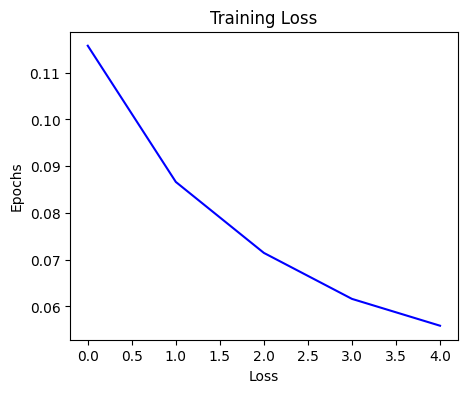

In [33]:
figure = plt.figure(figsize=(5,4))
plt.plot(range(0,epochs,1), train_loss_lenet, color ='b')
plt.xlabel("Loss")
plt.ylabel("Epochs")
plt.title("Training Loss")
plt.show()

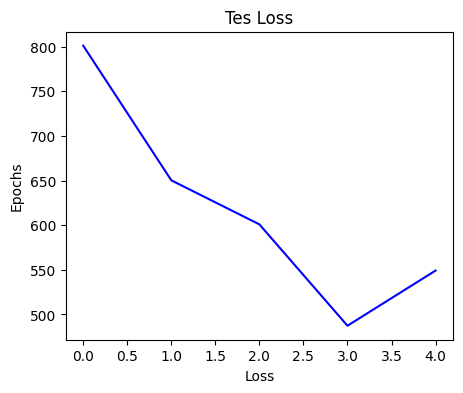

In [40]:
figure = plt.figure(figsize=(5,4))
plt.plot(range(0,epochs,1), test_loss_lenet, color ='b')
plt.xlabel("Loss")
plt.ylabel("Epochs")
plt.title("Tes Loss")
plt.show()

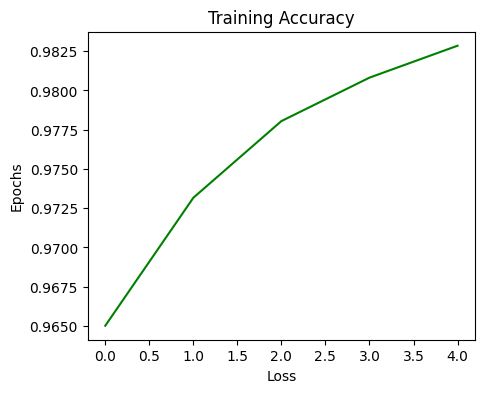

In [39]:
figure = plt.figure(figsize=(5,4))
plt.plot(range(0,epochs,1), train_acc_lenet, color ='g')
plt.xlabel("Loss")
plt.ylabel("Epochs")
plt.title("Training Accuracy")
plt.show()

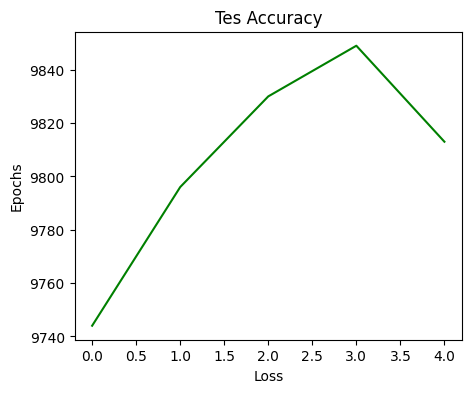

In [38]:
figure = plt.figure(figsize=(5,4))
plt.plot(range(0,epochs,1), test_acc_lenet, color ='g')
plt.xlabel("Loss")
plt.ylabel("Epochs")
plt.title("Tes Accuracy")
plt.show()

### 7. Let's Make Predictions with our model

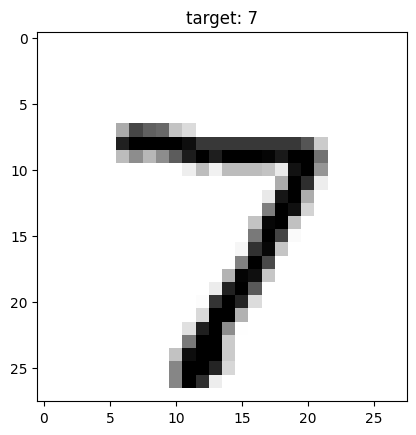

Predicted tensor([7], device='cuda:0')


In [80]:
image, target = test_data[0]
plt.imshow(image.permute(1,2,0), cmap="binary")
plt.title(f"target: {target}")
plt.show()

model.eval()
with torch.inference_mode():
  image = image.unsqueeze(0)
  prediction = model(image.to(device))

print(f"Predicted {prediction.argmax(1)}")